In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path("/scratch/sshah/2021-05-26/")
assert DATA_DIR.exists()

# def _cook(p: Path) -> pd.DataFrame
dfs = []
for f in DATA_DIR.glob("*test.csv.zip"):
    _df = pd.read_csv(f)
    assert _df.tuning.nunique() == 1
    if _df.tuning.unique()[0]:
        continue
    if _df.init_seed.unique() != [1000]:
        continue
    print(_df.damper.unique())
    dfs.append(_df)

['geodamp']
['radadamp']
['radadamp']
['geodamplr']
['geodamplr']
['radadamp']
['adagrad']


In [13]:
df = pd.concat(dfs, sort=False)

df.loc[(df.initial_batch_size == df.max_batch_size) & (df.damper == "radadamp"), "damper"] = "radadamplr"


df["epochs_binned"] = np.round(df["epochs"])
df["model_updates_binned"] = np.round(df["model_updates"], decimals=-2)

dampers = {
    "geodamplr": "SGD",
    "geodamp": "GeoDamp",
    "radadamp": "RadaDamp",
    "radadamplr": "RadaDamp-LR",
    "adagrad": "Adagrad",
}

HUE_ORDER = ["SGD", "GeoDamp", "RadaDamp", "RadaDamp-LR", "Adagrad"]
ACC_LIM = (0.865, 0.915)

df["Optimizer"] = df["damper"].apply(dampers.get)
df = df[df.init_seed == 1000].copy()

In [14]:
cols = ['initial_batch_size', 'max_batch_size', 'dampingfactor', 'dampingdelay', 'lr',
        'nesterov', 'momentum', 'weight_decay', 'init_seed']
print(df.columns)
cols = [c for c in df.columns if "opt_param" in c]
cols = ["loss_name", "rho", "dwell", "verbose", "no_cuda", "random_state", "init_seed", "damper", "approx_loss", "tuning"]
df.groupby("damper")[cols].nunique()

Index(['epoch_time', 'initial_batch_size', 'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay', 'epochs',
       'verbose', 'lr', 'no_cuda', 'random_state', 'init_seed', 'damper',
       'dataset', 'approx_loss', 'test_freq', 'rho', 'dwell', 'approx_rate',
       'nesterov', 'momentum', 'weight_decay', 'ident', 'tuning',
       'model_updates', 'num_examples', 'batch_loss', 'num_params',
       'len_dataset', 'device_type', 'loss_name', 'opt_name', 'opt_param_lr',
       'opt_param_momentum', 'opt_param_dampening', 'opt_param_weight_decay',
       'opt_param_nesterov', 'test_loss', 'test_accuracy', 'test_device',
       'test_prefix', '_epochs', '_num_examples', '_train_time', 'damping',
       '_step_time', 'time', 'step_time', 'lr_', 'batch_size_', 'fn_class',
       '_initial_norm2', '_batch_grad_norm2', '_batch_grad_norm',
       '_initial_loss', '_grad_mavg', '_loss_mavg', '_initial_factor',
       'opt_param_lr_decay', 'opt_param_eps',
       'opt_param_

,loss_name,rho,dwell,verbose,no_cuda,random_state,init_seed,damper,approx_loss,tuning
damper,,,,,,,,,,
adagrad,1,1,1,1,1,1,1,1,1,1
geodamp,1,1,1,1,1,1,1,1,1,1
geodamplr,1,1,1,1,1,1,1,1,1,1
radadamp,1,1,1,1,1,1,1,1,1,1
radadamplr,1,1,1,1,1,1,1,1,1,1


In [15]:
df.columns

Index(['epoch_time', 'initial_batch_size', 'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay', 'epochs',
       'verbose', 'lr', 'no_cuda', 'random_state', 'init_seed', 'damper',
       'dataset', 'approx_loss', 'test_freq', 'rho', 'dwell', 'approx_rate',
       'nesterov', 'momentum', 'weight_decay', 'ident', 'tuning',
       'model_updates', 'num_examples', 'batch_loss', 'num_params',
       'len_dataset', 'device_type', 'loss_name', 'opt_name', 'opt_param_lr',
       'opt_param_momentum', 'opt_param_dampening', 'opt_param_weight_decay',
       'opt_param_nesterov', 'test_loss', 'test_accuracy', 'test_device',
       'test_prefix', '_epochs', '_num_examples', '_train_time', 'damping',
       '_step_time', 'time', 'step_time', 'lr_', 'batch_size_', 'fn_class',
       '_initial_norm2', '_batch_grad_norm2', '_batch_grad_norm',
       '_initial_loss', '_grad_mavg', '_loss_mavg', '_initial_factor',
       'opt_param_lr_decay', 'opt_param_eps',
       'opt_param_

In [16]:
df.groupby("damper")["init_seed"].unique()

damper
adagrad       [1000]
geodamp       [1000]
geodamplr     [1000]
radadamp      [1000]
radadamplr    [1000]
Name: init_seed, dtype: object

In [17]:
df.head()

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,_initial_loss,_grad_mavg,_loss_mavg,_initial_factor,opt_param_lr_decay,opt_param_eps,opt_param_initial_accumulator_value,epochs_binned,model_updates_binned,Optimizer
0,1.622022e+09,256,1024,0.01,1.219231,10,0.000000,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,GeoDamp
1,1.622022e+09,256,1024,0.01,1.219231,10,1.002667,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,200,GeoDamp
2,1.622022e+09,256,1024,0.01,1.219231,10,2.005333,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,500,GeoDamp
3,1.622022e+09,256,1024,0.01,1.219231,10,3.008000,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,700,GeoDamp
4,1.622022e+09,256,1024,0.01,1.219231,10,4.010667,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,900,GeoDamp


In [18]:
def lineplot(
    *, x, y, hue, hue_order, ax, data, aggfunc="mean",
):
    for h in hue_order:
        show = data[data[hue] == h]
        if not len(show):
            continue
        middle = show.pivot_table(index=x, values=y, aggfunc=aggfunc)
        ax.plot(middle.index, middle.to_numpy(), label=h)
    return ax

PERC_FORMAT = plt.FuncFormatter(lambda x, _: f"{int(100 * x)}%")
MU_FORMAT = plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}")


[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


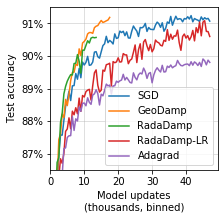

In [37]:
w = 3
fig, ax = plt.subplots(figsize=(w, w))

N = 500
df["model_updates_binned2"] = np.round(df["model_updates"] / N) * N

print(df.model_updates_binned2.unique()[:10])
ax = lineplot(
    x="model_updates_binned2",
    y="test_accuracy",
    hue="Optimizer",
#     aggfunc="max",
#     aggfunc=lambda x: np.percentile(x, 75),
    aggfunc="median",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
)
ax.legend(loc="best")
ax.set_ylim(*ACC_LIM)
ax.set_xlim(0, None)
ax.yaxis.set_major_formatter(PERC_FORMAT)
ax.xaxis.set_major_formatter(MU_FORMAT)

ax.grid(alpha=0.5)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Model updates\n(thousands, binned)")
fig.savefig("acc_mu.png", dpi=300, bbox_inches="tight")

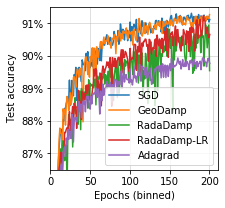

In [25]:
fig, ax = plt.subplots(figsize=(w, w))

df["epochs_binned"] = (df.epochs / 5) * 5
ax = lineplot(
    x="epochs_binned",
    y="test_accuracy",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
    aggfunc="median",
)
ax.set_ylim(*ACC_LIM)
ax.set_xlim(0, None)
ax.grid(alpha=0.5)
ax.yaxis.set_major_formatter(PERC_FORMAT)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Epochs (binned)")
ax.legend(loc="best")
fig.savefig("epochs-acc.png", dpi=300, bbox_inches="tight")

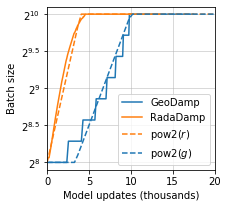

In [33]:
fig, ax = plt.subplots(figsize=(w, w))

show = df.copy()
idx = show.Optimizer == "RadaDamp"
ax = lineplot(
    x="model_updates",
    y="batch_size_",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=show[show.damper.isin(["radadamp", "geodamp"])],
)
ax.set_yscale("log", basey=2)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates (thousands)")
ylocs = [2**(i/2) for i in range(8, 30)]
ax.yaxis.set_major_locator(plt.FixedLocator(ylocs))
def _log_fmt(x, _):
    pwr = np.log2(x)
    if abs(pwr % 1.0) < 0.1:
        pwr = int(pwr)
    return "$2^{" + str(pwr) + "}$"
ax.yaxis.set_major_formatter(plt.FuncFormatter(_log_fmt))
ax.xaxis.set_major_formatter(MU_FORMAT)
ax.set_xlim(0, 20e3)

x = np.linspace(0, 20e3)
r = 5e-4
y = 2**(r*x + 8)
ax.plot(x, np.clip(y, 256, 1024), "C1--", label="pow$2(r)$")

r = 3e-4
y = 2**(r*x + 7)
ax.plot(x, np.clip(y, 256, 1024), "C0--", label="pow$2(g)$")
ax.legend(loc="best")
fig.savefig("bs.png", dpi=300, bbox_inches="tight")